In [1]:
import cv2
import numpy as np
import scipy
import matplotlib.pyplot as plt
import skimage

In [2]:
im_dir = "samples/duck.jpg"
img = cv2.imread(im_dir)
img = img.astype(np.float32)/255

<h1>Base Image</h1>

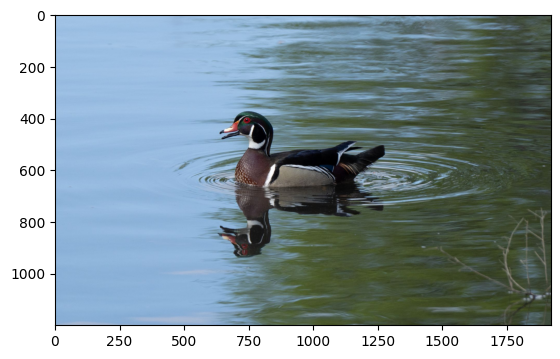

In [3]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

<h1>Noisy Image</h1>

In [4]:
mu = 0
sigma = 0.4
noise = np.random.normal(mu, sigma, size=img.shape)
img_noisy = img + noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8150272..2.7997146].


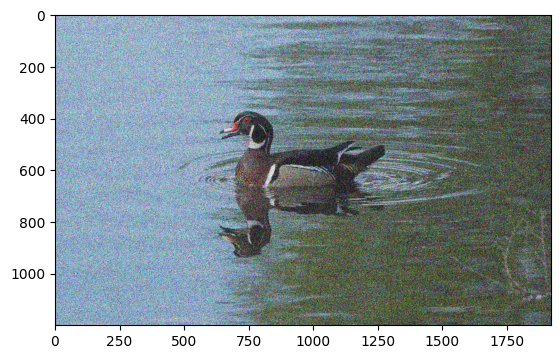

In [5]:
img_rgb = cv2.cvtColor(np.float32(img_noisy), cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

<h1>Noisy Image Denoised</h1>

In [6]:
img_denoised = skimage.restoration.denoise_wavelet(img_noisy, channel_axis=-1, convert2ycbcr=True, method='BayesShrink', mode='soft', rescale_sigma=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0739332..1.0369867].


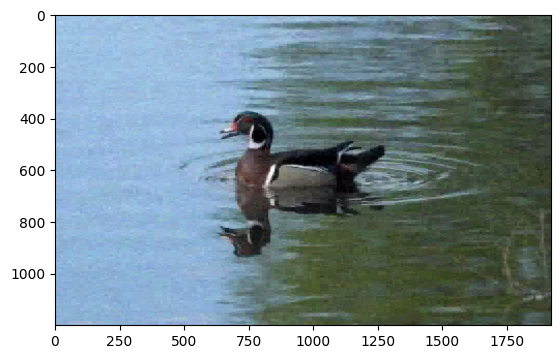

In [7]:
img_rgb = cv2.cvtColor(np.float32(img_denoised), cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

<h1>Blurred Image</h1>

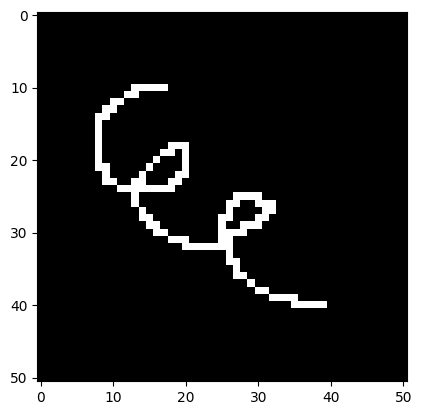

In [8]:
kernel_dir = "kernels/kernel_51x51.png"
kernel = cv2.imread(kernel_dir, cv2.IMREAD_GRAYSCALE)
kernel = kernel.astype(np.float32)/255
kernel = kernel/np.sum(kernel)
plt.imshow(kernel, cmap='gray')

In [9]:
img_blurry_b = scipy.ndimage.convolve(img[:,:,0], kernel, mode='mirror')
img_blurry_g = scipy.ndimage.convolve(img[:,:,1], kernel, mode='mirror')
img_blurry_r = scipy.ndimage.convolve(img[:,:,2], kernel, mode='mirror')
img_blurry = np.zeros(img.shape)
img_blurry[:,:,0] = img_blurry_b
img_blurry[:,:,1] = img_blurry_g
img_blurry[:,:,2] = img_blurry_r

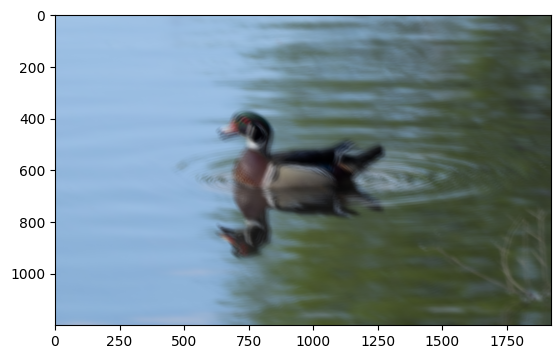

In [10]:
img_rgb = cv2.cvtColor(np.float32(img_blurry), cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

<h1>Kernel Estimation</h1>

In [11]:
b = img_blurry[200:1000, 500:1300 ,0].flatten()
A = np.zeros((b.shape[0], (51*51)))
I = img_denoised[200:1000,500:1300,0]
I_pad = img_denoised[175:1025,475:1325,0]
#I_pad = np.pad(I, ((25,25),(25,25)))
print(I_pad.shape)
print(A.shape)

(850, 850)
(640000, 2601)


In [12]:
for i in range(800):
    for j in range(800):
        conv_area = I_pad[i:i+51, j:j+51]
        A[i*I.shape[1]+j] = conv_area.flatten()

<h2>Least Squares Method</h2>

In [14]:
k_rec_lstsq = np.linalg.lstsq(A,b)

(2601,)


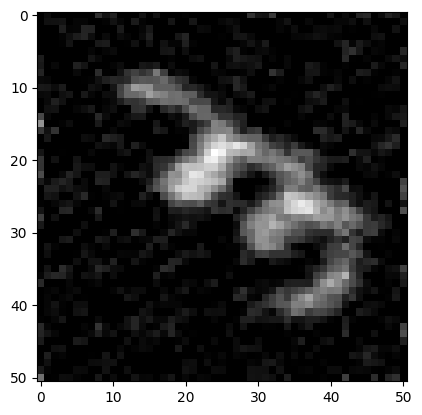

In [15]:
print(k_rec_lstsq[0].shape)
k_rec_lstsq_processed = k_rec_lstsq[0].copy()
k_rec_lstsq_processed[k_rec_lstsq_processed<0] = 0
plt.imshow(k_rec_lstsq_processed.reshape((51,51)), cmap='gray')

<h2>Landweber Method</h2>

In [31]:
b = img_blurry[200:1000, 500:1300 ,0].flatten()
A = np.zeros((b.shape[0], (51*51)))
I = img_denoised[200:1000,500:1300,0]
I_pad = img[175:1025,475:1325,0]
#I_pad = np.pad(I, ((25,25),(25,25)))
print(I_pad.shape)
print(A.shape)

(850, 850)
(640000, 2601)


In [32]:
for i in range(800):
    for j in range(800):
        conv_area = I_pad[i:i+51, j:j+51]
        A[i*I.shape[1]+j] = conv_area.flatten()

In [33]:
def landweber(A, b, beta=1.0, lamb=5.0):
    k = np.zeros(A.shape[1])
    k[0] = 1.0 # apply delta function
    print("Calculating ATb")
    ATb = A.T@b
    print("Calculating ATA with lambda")
    ATA_lambda = A.T@A + lamb**2 * np.eye(A.shape[1])
    print("Running iterative loop")
    for i in range(100):
        k_next = k + beta * (ATb - ATA_lambda@k)
        k_next[k_next < 0] = 0
        k_sum = np.sum(k_next)
        if (k_sum <= 0):
            k_next = np.zeros(A.shape[1])
            k_next[0] = 1.0
        else:
            k_next = k_next / k_sum
        convergence = np.linalg.norm(k_next - k)
        k = k_next.copy()
        if ((i%10)==0):
            print(convergence)
    return k

In [ ]:
k_rec_landweber = landweber(A,b)

Calculating ATb
Calculating ATA with lambda


In [ ]:
print(k_rec_landweber.shape)
plt.imshow(k_rec_landweber.reshape((51,51)), cmap='gray')